In [1]:
# Used for unpickling byte stream of python objects on file system/disk
import pickle
# Used for decompressing .gzip files from file system/disk
import gzip
# Used for array operations
import numpy as np

## Load MNIST

In [2]:
# Opening and decompressing .gzip file
filename = 'mnist.pkl.gz'
f = gzip.open(filename, 'rb')

# Unpickling .pkl file saved as byte stream on disk to python objects
trainingData, validationData, testingData = pickle.load(f, encoding='latin1')
f.close()

# Training feature vectors and training target extracted from trainingData (target represented using one-hot format)
trainingTarget = np.array([1 if  trainingData[1][i] == t else 0  for i in range(len(trainingData[1])) for t in range(10)]).reshape(-1,10)
trainingData = trainingData[0]

# Validation feature vectors and validation target extracted from validationData
validationTarget = validationData[1]
validationData = validationData[0]

# Testing feature vectors and testing target extracted from testingData 
testingTarget = testingData[1]
testingData = testingData[0]

## Load USPS

In [3]:
# Used to open image in file system/disk
from PIL import Image
# Used to navigate to required directory in the file system
import os
# Used to convert image data to array
import numpy as np

In [4]:
USPSMat  = []
USPSTar  = []
curPath  = 'USPSdata/Numerals'
savedImg = []

# Navigate to the 10 folders containing images for 10 labels
for j in range(0,10):
    curFolderPath = curPath + '/' + str(j)
    imgs =  os.listdir(curFolderPath)
    for img in imgs:
        curImg = curFolderPath + '/' + img
        if curImg[-3:] == 'png':
            
            # Open image resize it, and save image array as well as labels in 2 lists
            img = Image.open(curImg,'r')
            img = img.resize((28, 28))
            savedImg = img
            imgdata = (255-np.array(img.getdata()))/255
            USPSMat.append(imgdata)
            USPSTar.append(j)

# Logistic Regression

In [5]:
# Used for performing kmeans clustering, while computing radial basis functions
from sklearn.cluster import KMeans
# Used when random functions are required
import random as rd
# Used for math operations
import math
# Used for array operations
import numpy as np
# Used for populating the confusion matrix
from sklearn.metrics import confusion_matrix

In [6]:
# Function to generate big sigma, which is a measure of how the input data spreads for each feature in the dataset
def GenerateBigSigma(Data, MuMatrix,IsSynthetic = False):
    
    #  Create empty matrix of size (f,f) where f is number of features in dataset    
    BigSigma    = np.zeros((len(Data[0]),len(Data[0])))
       
    # Ensures that variance is calculated only on 80% of input data used for training 
    TrainingLen = math.ceil(len(Data))   
    varVect     = []
    
    # Calculate variance for each of 41 features
    for i in range(0,len(Data[0])):
        vct = []
        for j in range(0,int(TrainingLen)):
            vct.append(Data[j][i])    
        varVect.append(np.var(vct))
    
    # The variances computed in the previous step are used to generate the (fxf) diagonal matrix big sigma
    for j in range(len(Data[0])):
        BigSigma[j][j] = varVect[j]
        
    # Value of big sigma multiplied with a large number to ensure its value stays significant
    if IsSynthetic == True:
        BigSigma = np.dot(3,BigSigma)
    else:
        BigSigma = np.dot(200,BigSigma)
    ##print ("BigSigma Generated..")
    return BigSigma

# This function does (x-mu)*(sigma^-1)(s-mu), where x is a single row from the data set and mu is one of the M cluster centroids and sigma^-1 is matrix inverse of big sigma
def GetScalar(DataRow,MuRow, BigSigInv):  
    R = np.subtract(DataRow,MuRow)
    T = np.dot(BigSigInv,np.transpose(R))  
    L = np.dot(R,T)
    return L

# Function to get e^(-0.5X), where X is the scalar value returned from the GetScalar function
def GetRadialBasisOut(DataRow,MuRow, BigSigInv):    
    phi_x = math.exp(-0.5*GetScalar(DataRow,MuRow,BigSigInv))
    return phi_x

# Function to generate the phi matrix, the matrix representation of the values of radial basis functions of the input with M centroids,
# which will be used to train the parameters in linear regression. RBFs are used to introduce non-linearity in the model.
def GetPhiMatrix(Data, MuMatrix, BigSigma):
    
           
    PHI = np.zeros((int(len(Data)),len(MuMatrix))) 
    
    # Get matrix inverse of big sigma
    BigSigInv = np.linalg.pinv(BigSigma)
    
    # Calculate value of the radial basis function for each sample in the input data set with each M centroid, for the big sigma calculated
    for  C in range(0,len(MuMatrix)):
        for R in range(0,int(len(Data))):
            PHI[R][C] = GetRadialBasisOut(Data[R], MuMatrix[C], BigSigInv)
    #print ("PHI Generated..")
    return PHI

# Function to compute performance of the logistic regression model for given training/validation/test predicted labels and their corresponding targets
def GetErmsLogistic(VAL_TEST_OUT,ValDataAct):
    
    # Get label from one-hot representaion
    VAL_TEST_OUT = np.argmax(VAL_TEST_OUT, axis =1)
    ValDataAct = ValDataAct
    sum = 0.0
    t=0
    accuracy = 0.0
    counter = 0
    val = 0.0
    
    # Computing accuracy by comparing test labels and predicted labels
    for i in range (0,len(VAL_TEST_OUT)):
        if(VAL_TEST_OUT[i] == ValDataAct[i]):
            counter+=1
    accuracy = (float((counter*100))/float(len(VAL_TEST_OUT)))
    ##print ("Accuracy Generated..")
    ##print ("Validation E_RMS : " + str(math.sqrt(sum/len(VAL_TEST_OUT))))
    return (str(accuracy) + ',' +  str(math.sqrt(sum/len(VAL_TEST_OUT))))

In [7]:
# Function to simulate both linear and logistic regression models given datasets and hyper-parameters
def predictiveModel(mode, trainingData, trainingTarget, M=100, learningRate=0.001, La=0.005, BATCH_SIZE=1, EPOCHS=10):
    
    # If radial chosen, applies kmeans clustering, computes Mu and bigsigma to generate phi matrices
    if mode == 'Radial':
        kmeans = KMeans(n_clusters=M, random_state=0).fit(trainingData)
        Mu = kmeans.cluster_centers_
        BigSigma     = GenerateBigSigma(trainingData, Mu)
        TRAINING_PHI = GetPhiMatrix(trainingData, Mu, BigSigma)
        TEST_PHI     = GetPhiMatrix(testingData, Mu, BigSigma) 
        VAL_PHI      = GetPhiMatrix(validationData, Mu, BigSigma)

    # If radial is not chosen, generates phi matrices by adding a feature of ones to the feature vectors to accomodate bias
    else:
        TRAINING_PHI = np.append(np.ones((len(trainingData), 1)),trainingData, axis=1)
        TEST_PHI     = np.append(np.ones((len(testingData), 1)),testingData, axis=1)
        VAL_PHI      = np.append(np.ones((len(validationData), 1)),validationData, axis=1)
    
    np.random.seed = 0
    W_Now        = np.dot(np.random.rand(len(trainingData[0])+1,len(trainingTarget[0])),1)
    L_Erms_Val   = []
    L_Erms_TR    = []
    L_Erms_Test  = []
    
    # Runs mini-batch gradient descent with BATCH_SIZE over EPOCHS epochs
    for ep in range(EPOCHS):
        randIdx = [x for x in range(len(trainingTarget))]
        np.random.shuffle(randIdx)
        TRAINING_PHI = TRAINING_PHI[randIdx]
        trainingTarget = trainingTarget[randIdx]
        
        for start in range(0,int(len(trainingData)),BATCH_SIZE):
            end = start+BATCH_SIZE
            
            # Computing gradient of cross entropy error function w.r.t weights and updating weights to minimize cross entropy error
            expWTX = np.exp(np.matmul(TRAINING_PHI[start:end], W_Now))
            Delta_E_D     = -np.matmul(np.transpose(TRAINING_PHI[start:end]),(trainingTarget[start:end] - (expWTX/np.sum(expWTX, axis = 1, keepdims = True))))
            La_Delta_E_W  = np.dot(La,W_Now)
            Delta_E       = np.add(Delta_E_D,La_Delta_E_W)    
            Delta_W       = -np.dot(learningRate,Delta_E)
            W_T_Next      = W_Now + Delta_W
            W_Now         = W_T_Next
            expWTX = np.exp(np.matmul(TRAINING_PHI, W_Now))
            
            # -----------------TrainingData Accuracy---------------------#
            TR_TEST_OUT   = expWTX/np.sum(expWTX, axis = 1, keepdims = True)
            Erms_TR       = GetErmsLogistic(TR_TEST_OUT,np.argmax(trainingTarget, axis=1))
            L_Erms_TR.append(float(Erms_TR.split(',')[0]))

    print ('--------------Gradient Descent----------------\n')
    expWTX = np.exp(np.matmul(VAL_PHI, W_Now))
    #-----------------ValidationData Accuracy---------------------#
    VAL_TEST_OUT  = expWTX/np.sum(expWTX, axis = 1, keepdims = True)
    Erms_Val      = GetErmsLogistic(VAL_TEST_OUT,validationTarget)
    L_Erms_Val.append(float(Erms_Val.split(',')[0]))

    expWTX = np.exp(np.matmul(TEST_PHI, W_Now))
    #-----------------MNIST TestingData Accuracy---------------------#
    TEST_OUT      = expWTX/np.sum(expWTX, axis = 1, keepdims = True)
    Erms_Test = GetErmsLogistic(TEST_OUT,testingTarget)
    L_Erms_Test.append(float(Erms_Test.split(',')[0]))

    expWTX = np.exp(np.matmul(np.append(np.ones((len(USPSMat), 1)),USPSMat, axis=1), W_Now))
    #-----------------USPS TestingData Accuracy---------------------#
    USPS_TEST_OUT      = expWTX/np.sum(expWTX, axis = 1, keepdims = True)
    Erms_USPSTest = GetErmsLogistic(USPS_TEST_OUT,USPSTar)
    
    print ("Training accuracy        = " + str(np.around(L_Erms_TR[len(L_Erms_TR)-1],5)))
    print ("Validation accuracy      = " + str(np.around(L_Erms_Val[len(L_Erms_Val)-1],5)))
    print ("Testing accuracy         = " + str(np.around(L_Erms_Test[len(L_Erms_Test)-1],5)))
    print ("USPS Testing Accuracy    = " + str(np.around(float(Erms_USPSTest.split(',')[0]))),"\n")

    return L_Erms_TR, np.argmax(TEST_OUT, axis=1), np.argmax(USPS_TEST_OUT, axis=1)

In [8]:
# The commented section below was used to validate the logistic regression model using a grid search of the following hyper-parameters
# lr_list = [0.1, 0.03, 0.01, 0.005]
# lam_list = [0.3, 0.1, 0.03, 0.01]
# batch_list = [20, 50, 100]

# for learningRate in lr_list:
#     for La in lam_list:
#         for BATCH_SIZE in batch_list:
#             print("\nLearning rate: ", str(learningRate), "Lambda: ", str(La), "Batch size: ", str(BATCH_SIZE), "\n\n")
#             training, logMNISTPrediction, logUSPSPrediction = predictiveModel(None, trainingData, trainingTarget, 100, learningRate, La, BATCH_SIZE, EPOCHS=1)

# Training algorithm again on the best set of hyper-parameters (which give the best validation accuracy)
# to get the best training accuracy
training, logMNISTPrediction, logUSPSPrediction = predictiveModel(None, trainingData, trainingTarget, M=100, learningRate=0.01, La=0.01, BATCH_SIZE=20, EPOCHS=1)
print("\nMNIST Confusion Matrix: \n\n",confusion_matrix(testingTarget, logMNISTPrediction))
print("\nUSPS Confusion Matrix: \n\n",confusion_matrix(USPSTar, logUSPSPrediction))

--------------Gradient Descent----------------

Training accuracy        = 90.416
Validation accuracy      = 90.98
Testing accuracy         = 90.7
USPS Testing Accuracy    = 33.0 


MNIST Confusion Matrix: 

 [[ 970    0    1    3    1    2    1    1    1    0]
 [   0 1110    3    3    1    2    3    1   12    0]
 [  23   16  854   28   18    1    7   12   65    8]
 [   7    1    9  935    1   17    1   11   18   10]
 [   4    2    3    0  927    0    3    2    6   35]
 [  22    5    3   55   12  740    9    5   33    8]
 [  33    3   10    3   37   13  847    3    9    0]
 [   4   11   15    7    8    1    0  932    6   44]
 [  16    9    3   26   10   23    6   10  861   10]
 [  14    8    2   13   47    5    0   18    8  894]]

USPS Confusion Matrix: 

 [[ 551    1  257   45  196  293   76   92  124  365]
 [ 168  294  215  259  345  135   11  358  161   54]
 [ 300   21 1111  136   67  171   42   54   67   30]
 [ 149    4  165 1037   33  402    8   67   77   58]
 [  62   37   56   44

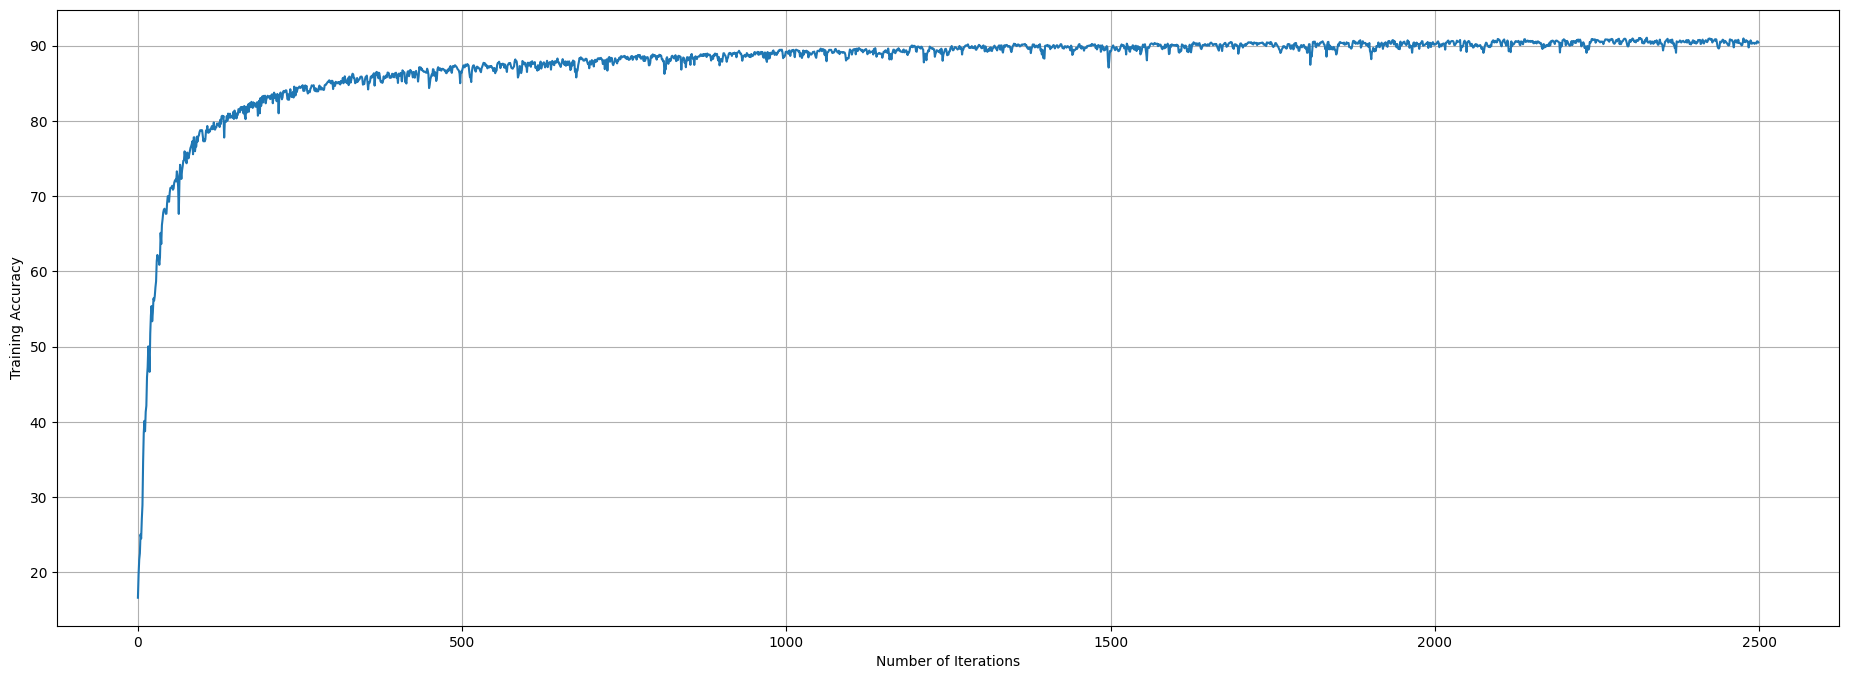

In [9]:
# The matplotlib package is used for plotting graphs
import matplotlib
import matplotlib.pyplot as plt 
# Outputs training accuracy for each iteration of gradient descent
fig2, ax2=plt.subplots(figsize=(23,8))
ax2.plot( training)
ax2.set(xlabel='Number of Iterations', ylabel='Training Accuracy')
ax2.grid()
plt.show()

# SVM

In [10]:
import numpy as np
from sklearn.svm import SVC

In [11]:
# SVM classifier from scikit learn
SVMclassifier = SVC(kernel='rbf')#, C=1, gamma = 0.05);
# Picking 10,000 random samples from dataset
randIdx = [x for x in range(len(trainingData))]
np.random.shuffle(randIdx)
SVMclassifier.fit(trainingData[randIdx[:10000]], np.argmax(trainingTarget[randIdx[:10000]], axis=1))

SVC()

In [12]:
svmValPrediction = SVMclassifier.predict(validationData)
svmMNISTPrediction = SVMclassifier.predict(testingData)
svmUSPSPrediction = SVMclassifier.predict(USPSMat)

print ('---------------SVM----------------\n')
print('Validation accuracy       = ', np.mean(svmValPrediction == validationTarget)*100)
print('MNIST Testing accuracy    = ', np.mean(svmMNISTPrediction == testingTarget)*100)
print('USPS Testing accuracy     = ', np.mean(svmUSPSPrediction == USPSTar)*100,"\n")
print("\nMNIST Confusion Matrix: \n\n",confusion_matrix(testingTarget, svmMNISTPrediction))
print("\nUSPS Confusion Matrix: \n\n",confusion_matrix(USPSTar, svmUSPSPrediction))

---------------SVM----------------

Validation accuracy       =  96.74000000000001
MNIST Testing accuracy    =  96.26
USPS Testing accuracy     =  39.15195759787989 


MNIST Confusion Matrix: 

 [[ 969    0    1    0    0    4    4    1    1    0]
 [   0 1124    2    2    0    1    4    0    2    0]
 [   5    1  992    7    1    0    5   10   11    0]
 [   0    0   10  974    0    6    0    9    9    2]
 [   1    0    5    0  942    0    7    3    2   22]
 [   5    1    3   21    2  840   10    1    6    3]
 [   9    3    1    0    3    5  936    0    1    0]
 [   1   13   16    1    4    0    0  972    1   20]
 [   3    0    4   11    6    5    8    4  930    3]
 [   6    5    3   10   18    5    0   10    5  947]]

USPS Confusion Matrix: 

 [[ 576    1  607   11  170  250   63   17    6  299]
 [ 141  446  309  107  249  175   44  496   19   14]
 [ 114    5 1553   43   17  166   38   48    9    6]
 [  43    0  256 1224    1  437    3   26    6    4]
 [  34   14  187   10 1012  314   2

# Random Forest

In [13]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier

In [14]:
#RandomForest Classifier from scikit learn
RFclassifier = RandomForestClassifier(n_estimators=200, n_jobs=-1);

# RFclassifier.fit(trainingData[randIdx[:10000]], np.argmax(trainingTarget[randIdx[:10000]], axis=1))
RFclassifier.fit(trainingData, np.argmax(trainingTarget, axis=1))

RandomForestClassifier(n_estimators=200, n_jobs=-1)

In [15]:
rfValPrediction = RFclassifier.predict(validationData)
rfMNISTPrediction = RFclassifier.predict(testingData)
rfUSPSPrediction = RFclassifier.predict(USPSMat)

print ('---------------Random Forest----------------\n')
print('Validation accuracy    = ', np.mean(rfValPrediction == validationTarget)*100)
print('MNIST Testing accuracy = ', np.mean(rfMNISTPrediction == testingTarget)*100)
print('USPS Testing accuracy  = ', np.mean(rfUSPSPrediction == USPSTar)*100,"\n")
print("\nMNIST Confusion Matrix: \n\n",confusion_matrix(testingTarget, rfMNISTPrediction))
print("\nUSPS Confusion Matrix: \n\n",confusion_matrix(USPSTar, rfUSPSPrediction))

---------------Random Forest----------------

Validation accuracy    =  97.26
MNIST Testing accuracy =  96.94
USPS Testing accuracy  =  40.177008850442526 


MNIST Confusion Matrix: 

 [[ 971    0    1    0    0    1    2    1    4    0]
 [   0 1122    2    4    0    1    3    1    2    0]
 [   6    0 1001    5    3    0    3    8    6    0]
 [   1    0   10  974    0    7    0    8    7    3]
 [   1    0    1    0  957    0    5    0    2   16]
 [   3    0    0   12    4  859    7    1    3    3]
 [   6    3    0    0    5    3  937    0    4    0]
 [   1    4   21    1    1    0    0  986    3   11]
 [   4    0    6    9    4    5    4    4  929    9]
 [   6    5    3   10   12    1    1    4    9  958]]

USPS Confusion Matrix: 

 [[ 651   15  269   53  426  154   73  109    5  245]
 [  53  565  124  116   45   87   23  970   16    1]
 [  89   31 1293   66   37  177   25  273    5    3]
 [  42    6   97 1292   59  320    3  165    5   11]
 [  11  225   55   27 1078  172   11  385   2

# Neural Network

In [16]:
import keras
from keras.datasets import mnist
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten

In [17]:
#DNN
num_classes = len(trainingTarget[0])
DNNclassifier = Sequential()
DNNclassifier.add(Dense(units=200, activation='relu', input_shape=(len(trainingData[0]),)))
DNNclassifier.add(Dropout(0.2))
DNNclassifier.add(Dense(units=200, activation='relu'))
DNNclassifier.add(Dropout(0.2))
# DNNclassifier.add(Dense(units=200, activation='relu'))
# DNNclassifier.add(Dropout(0.2))
DNNclassifier.add(Dense(units=num_classes, activation='softmax'))
DNNclassifier.compile(optimizer='Adamax', loss='categorical_crossentropy',metrics=['accuracy'])
history = DNNclassifier.fit(trainingData, trainingTarget, batch_size=128, epochs=100,
verbose=False,validation_data=(validationData, keras.utils.to_categorical(validationTarget, num_classes)))

/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
loss,valAccuracy = DNNclassifier.evaluate(validationData, keras.utils.to_categorical(validationTarget, num_classes), verbose=False)
loss,testAccuracy = DNNclassifier.evaluate(testingData, keras.utils.to_categorical(testingTarget, num_classes), verbose=False)
loss,testUSPSAccuracy = DNNclassifier.evaluate(np.array(USPSMat), keras.utils.to_categorical(USPSTar, num_classes), verbose=False)
dnnMNISTPrediction = np.argmax(DNNclassifier.predict(testingData), axis=1)
dnnUSPSPrediction = np.argmax(DNNclassifier.predict(np.array(USPSMat)), axis=1)

print ('---------------DNN----------------\n')
print('Validation accuracy    = ', valAccuracy*100)
print('MNIST Testing accuracy = ', testAccuracy*100)
print('USPS Testing accuracy  = ', testUSPSAccuracy*100,'"\n"')
print("\nMNIST Confusion Matrix: \n\n",confusion_matrix(testingTarget, dnnMNISTPrediction))
print("\nUSPS Confusion Matrix: \n\n",confusion_matrix(USPSTar, dnnUSPSPrediction))

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step
---------------DNN----------------

Validation accuracy    =  98.35000038146973
MNIST Testing accuracy =  98.32000136375427
USPS Testing accuracy  =  46.89234495162964 "
"

MNIST Confusion Matrix: 

 [[ 969    0    1    1    0    1    4    1    3    0]
 [   0 1127    3    0    0    0    2    1    2    0]
 [   2    2 1017    2    1    0    0    5    3    0]
 [   0    0    3  996    0    2    0    5    4    0]
 [   0    0    0    0  963    0    6    0    1   12]
 [   1    0    0   10    1  871    4    0    3    2]
 [   3    2    1    1    2    3  946    0    0    0]
 [   0    5    8    1    1    0    0 1005    4    4]
 [   1    0    3    3    3    2    0    3  956    3]
 [   2    2    0    4    8    4    0    5    2  982]]

USPS Confusion Matrix: 

 [[ 556    4  239   93  101  201  200  262   44  300]
 [  30  453  507   80  214   97   13  522   55   29]
 [  26   15 1644   49   14   88   78   49   35    

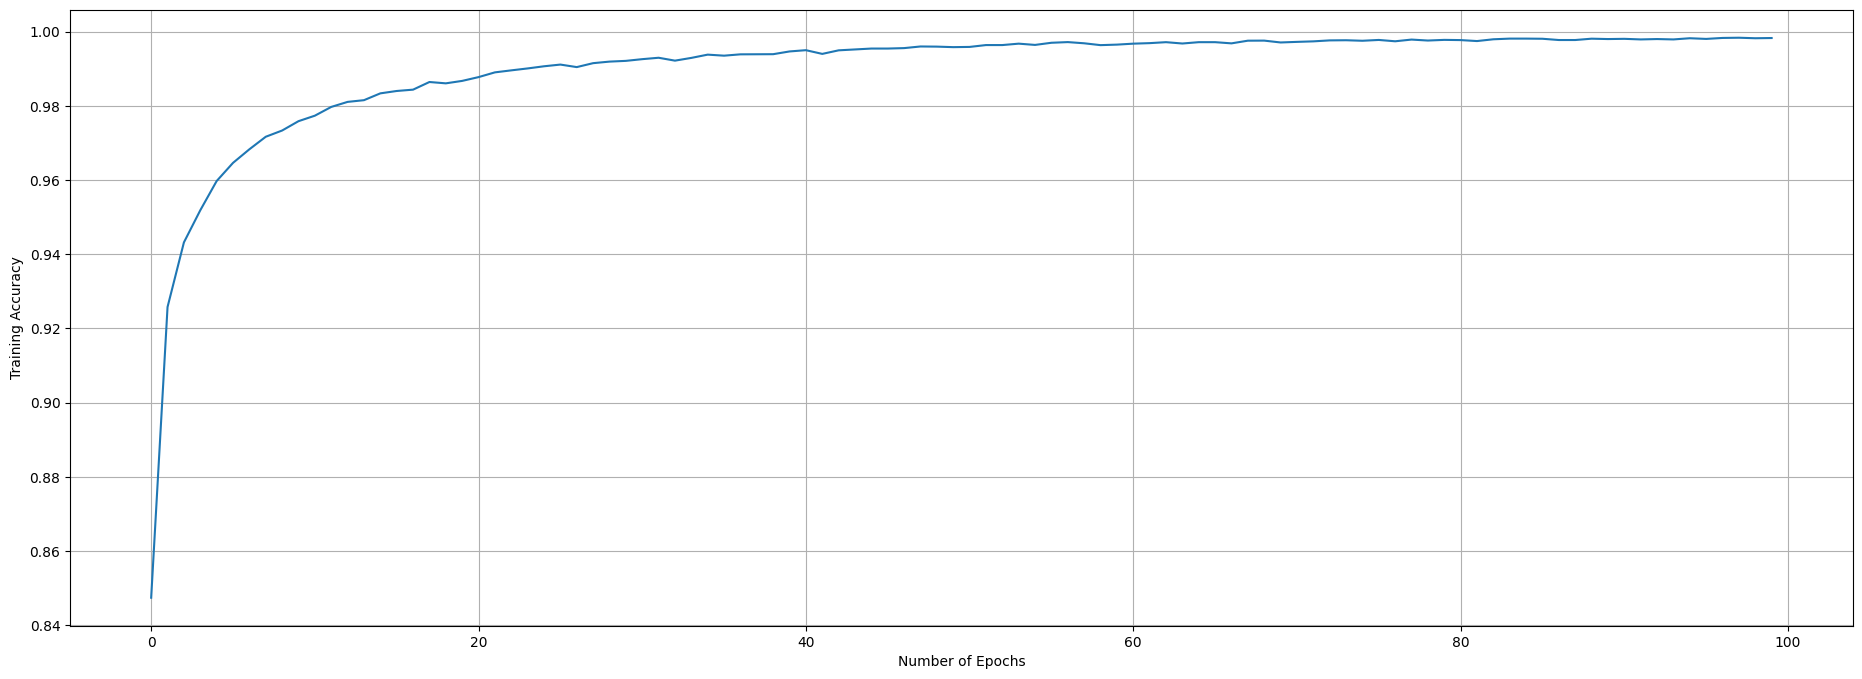

In [19]:
import matplotlib.pyplot as plt

# Outputs training accuracy and loss against epochs
fig2, ax2 = plt.subplots(figsize=(23, 8))

# Update the key to 'accuracy'
ax2.plot(history.history['accuracy'])
ax2.set(xlabel='Number of Epochs', ylabel='Training Accuracy')
ax2.grid()
plt.show()

In [20]:
#CNN
CNNclassifier = Sequential()
CNNclassifier.add(Conv2D(20, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)))
CNNclassifier.add(MaxPooling2D(pool_size=(2, 2)))
CNNclassifier.add(Conv2D(20, (3, 3), activation='relu'))
CNNclassifier.add(MaxPooling2D(pool_size=(2, 2)))
CNNclassifier.add(Flatten())
CNNclassifier.add(Dense(units=200, activation='relu'))
CNNclassifier.add(Dropout(0.2))
CNNclassifier.add(Dense(units=200, activation='relu')) 
CNNclassifier.add(Dropout(0.2))
CNNclassifier.add(Dense(units=num_classes, activation='softmax'))
CNNclassifier.compile(optimizer='Adamax', loss='categorical_crossentropy',metrics=['accuracy'])
history = CNNclassifier.fit(trainingData.reshape(-1, 28, 28, 1), trainingTarget, batch_size=128, epochs=10,
verbose=True,validation_data=(validationData.reshape(-1, 28, 28, 1), keras.utils.to_categorical(validationTarget, num_classes)))

Epoch 1/10


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.7099 - loss: 0.9448 - val_accuracy: 0.9592 - val_loss: 0.1407
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9490 - loss: 0.1688 - val_accuracy: 0.9712 - val_loss: 0.0950
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9637 - loss: 0.1180 - val_accuracy: 0.9781 - val_loss: 0.0745
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9729 - loss: 0.0889 - val_accuracy: 0.9829 - val_loss: 0.0615
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9777 - loss: 0.0708 - val_accuracy: 0.9830 - val_loss: 0.0602
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9804 - loss: 0.0648 - val_accuracy: 0.9858 - val_loss: 0.0517
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9831 - loss: 0.0538 - val_accuracy: 0.9864 - val_loss: 0.0492
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9839 - loss: 0.0516 - val_accuracy: 0.987

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,        
    width_shift_range=0.2,    
    height_shift_range=0.2,   
    shear_range=0.2,          
    zoom_range=0.2,           
    horizontal_flip=True,     
    fill_mode='nearest'       
)

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

trainingData_augmented = trainingData.reshape(-1, 28, 28, 1)  

CNNclassifier.fit(datagen.flow(trainingData_augmented, trainingTarget, batch_size=128),
                  epochs=10,
                  validation_data=(validationData.reshape(-1, 28, 28, 1), keras.utils.to_categorical(validationTarget, num_classes)))


Epoch 1/10
  5/391 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.2643 - loss: 4.2824  

/opt/homebrew/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.4446 - loss: 1.8562 - val_accuracy: 0.9514 - val_loss: 0.2351
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.6799 - loss: 0.9458 - val_accuracy: 0.9552 - val_loss: 0.1866
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.7402 - loss: 0.7642 - val_accuracy: 0.9564 - val_loss: 0.1581
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.7766 - loss: 0.6682 - val_accuracy: 0.9630 - val_loss: 0.1290
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.8074 - loss: 0.5840 - val_accuracy: 0.9631 - val_loss: 0.1234
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.8188 - loss: 0.5540 - val_accuracy: 0.9647 - val_loss: 0.1221
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.8361 - loss: 0.5087 - val_accuracy: 0.9683 - val_loss: 0.1062
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.8422 - loss: 0.4848 - val_accuracy: 0.969

In [22]:
loss,valAccuracy = CNNclassifier.evaluate(validationData.reshape(-1, 28, 28, 1), keras.utils.to_categorical(validationTarget, num_classes), verbose=False)
loss,testAccuracy = CNNclassifier.evaluate(testingData.reshape(-1, 28, 28, 1), keras.utils.to_categorical(testingTarget, num_classes), verbose=False)
loss,testUSPSAccuracy = CNNclassifier.evaluate(np.array(USPSMat).reshape(-1, 28, 28, 1), keras.utils.to_categorical(USPSTar, num_classes), verbose=False)
cnnMNISTPrediction = np.argmax(CNNclassifier.predict(testingData.reshape(-1, 28, 28, 1)), axis=1)
cnnUSPSPrediction = np.argmax(CNNclassifier.predict(np.array(USPSMat).reshape(-1, 28, 28, 1)), axis=1)

print ('---------------CNN----------------\n')
print('Validation accuracy    = ', valAccuracy*100)
print('MNIST Testing accuracy = ', testAccuracy*100)
print('USPS Testing accuracy  = ', testUSPSAccuracy*100,"\n")
print("\nMNIST Confusion Matrix: \n\n",confusion_matrix(testingTarget, cnnMNISTPrediction))
print("\nUSPS Confusion Matrix: \n\n",confusion_matrix(USPSTar, cnnUSPSPrediction))

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
---------------CNN----------------

Validation accuracy    =  96.85999751091003
MNIST Testing accuracy =  96.78999781608582
USPS Testing accuracy  =  82.18910694122314 


MNIST Confusion Matrix: 

 [[ 970    0    0    0    0    1    7    1    1    0]
 [   0 1123    5    1    1    1    3    1    0    0]
 [   2    0  961    2    1   25   31    3    6    1]
 [   2    1    3  976    0   18    3    2    5    0]
 [   1    1    0    0  966    0    2    0    1   11]
 [   1    0   16   11    0  852    4    5    3    0]
 [   3    3    6    0    2    1  941    0    2    0]
 [   0    1   12    4    6   12    0  978    4   11]
 [   1    0    2    3    1    2    3    1  953    8]
 [   3    0    0    9    8    7    1   14    8  959]]

USPS Confusion Matrix: 

 [[1537    0   28   13   74   19  128    4  124   73]
 [  29 1467   20   11  227    9  103   49   62   23]
 [   9    2 1581   86   20   89   58   19  125   10]
 [ 

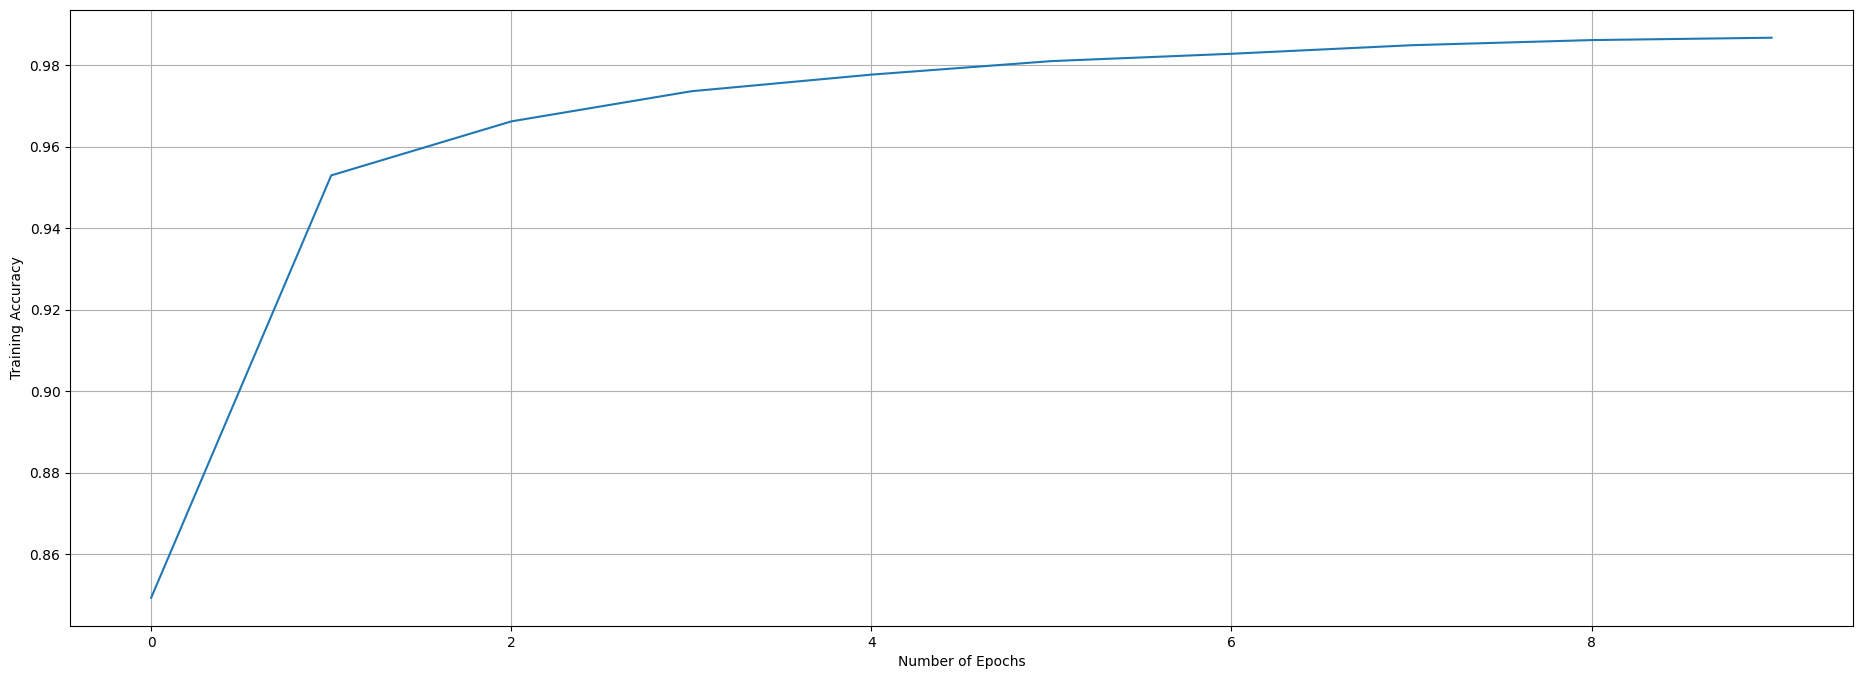

In [23]:
# The matplotlib package is used for plotting graphs
import matplotlib.pyplot as plt

# Outputs training accuracy and loss against epochs
fig2, ax2 = plt.subplots(figsize=(23, 8))

# Update 'acc' to 'accuracy'
ax2.plot(history.history['accuracy'])
ax2.set(xlabel='Number of Epochs', ylabel='Training Accuracy')
ax2.grid()
plt.show()


# Ensemble classifier

In [24]:
from scipy import stats
# Appending all predictions into a single array
appendedPredictions = np.append(np.append(np.append(logMNISTPrediction.reshape(len(testingTarget),1), 
                                                    svmMNISTPrediction.reshape(len(testingTarget),1), axis=1),
                                          np.append(rfMNISTPrediction.reshape(len(testingTarget),1), 
                                                    dnnMNISTPrediction.reshape(len(testingTarget),1), axis=1),axis=1), 
                                cnnMNISTPrediction.reshape(len(testingTarget),1), axis=1)

appendedUSPSPredictions = np.append(np.append(np.append(logUSPSPrediction.reshape(len(USPSTar),1), 
                                                    svmUSPSPrediction.reshape(len(USPSTar),1), axis=1),
                                          np.append(rfUSPSPrediction.reshape(len(USPSTar),1), 
                                                    dnnUSPSPrediction.reshape(len(USPSTar),1), axis=1),axis=1), 
                                cnnUSPSPrediction.reshape(len(USPSTar),1), axis=1)

In [25]:
# Computing mode of predictions of each classifier to get majority voting
ensemblePrediction, freq = stats.mode(np.transpose(appendedPredictions))
ensembleUSPSPrediction, freq = stats.mode(np.transpose(appendedUSPSPredictions))

print("Ensemble MNIST Accuracy = ", np.mean(ensemblePrediction == testingTarget)*100)
print("Ensemble USPS Accuracy  = ", np.mean(ensembleUSPSPrediction == np.array(USPSTar))*100)
print("\nMNIST Confusion Matrix: \n\n",confusion_matrix(ensemblePrediction.flatten(), cnnMNISTPrediction))
print("\nUSPS Confusion Matrix: \n\n",confusion_matrix(ensembleUSPSPrediction.flatten(), cnnUSPSPrediction))

Ensemble MNIST Accuracy =  97.47
Ensemble USPS Accuracy  =  47.36236811840592

MNIST Confusion Matrix: 

 [[ 971    0    5    3    0    0   12    1    5    1]
 [   0 1121    1    0    2    1    5    6    1    4]
 [   0    0  958    6    2   23   29    7    8    2]
 [   3    2    5  970    0   22    5    0   12    5]
 [   1    1    0    0  962    2    3    2    5    7]
 [   1    2   14   10    0  846    3    3    5    0]
 [   3    2    9    1    3    1  935    0    3    0]
 [   0    0    7    4    5   17    0  973    4    7]
 [   3    1    5    8    2    2    3    1  935    8]
 [   1    0    1    4    9    5    0   12    5  956]]

USPS Confusion Matrix: 

 [[ 824   83   83   63   71   78  276   49  156   27]
 [   7  473    6    8  110   16   44  200   27  133]
 [ 320  136 1604  217  206  206  369  435  401  203]
 [  10   58   56 1468   23  101   44  283  294  241]
 [ 147  186   42    3 1322    4   71   36   62  131]
 [  87   65  133  308  283 1467  290  252  898   87]
 [  54   13   23  